In [28]:
#imports


from __future__ import print_function

import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

/Users/tyronehou/.virtualenvs/pytorch/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [29]:
# generate data
np.random.seed(2)

T = 20
L = 1000
N = 100

x = np.empty((N, L), 'int64')
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
data = np.sin(x / 1.0 / T).astype('float64')
torch.save(data, open('traindata.pt', 'wb'))

In [30]:
# Import the data
# Data shape 5 dim vector []

In [106]:
# Sequence model

class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(5, 51)
        self.lstm2 = nn.LSTMCell(51, 51)
        self.linear = nn.Linear(51, 5)

    def forward(self, input, future = 0):
        outputs = []
        
        h_t = Variable(torch.zeros(input.size(0), 51).double(), requires_grad=False)
        c_t = Variable(torch.zeros(input.size(0), 51).double(), requires_grad=False)
        h_t2 = Variable(torch.zeros(input.size(0), 51).double(), requires_grad=False)
        c_t2 = Variable(torch.zeros(input.size(0), 51).double(), requires_grad=False)
        
        # run 19 times
        # input_t.size = 5 x 5
        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            input_t = input_t.squeeze(1)
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
        
        outputs += [output]
        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            #outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [174]:
# # set random seed to 0
# np.random.seed(0)
# torch.manual_seed(0)

# load data and make training set
data = pd.read_csv('cleaned/states_2017-08-28-00.csv')
# print(data['NMAC_id'][5])

# data_nparr = data.as_matrix()
# print(data_nparr[0])


# # drop unneeded columns to form matrix to be trained on
# data_matr = data.drop(['NMAC_id', 'alert_1', 'alert_2', 'onground_1', 'onground_2'], axis=1).as_matrix().astype('float')
# # print(data_m)

# restructure data
all_planes = []

batch_size = 1000
limit_timesteps = 20
count = 0
unique_icao = data.icao24.unique()
for i, name in enumerate(unique_icao):
    if count % 100 == 0: print(count)
    # only get batch size for now
    if count >= batch_size:
        break
    
    # get rows where icao == name (boolean vector)
    selector = data['icao24'] == name
    one_plane_df = data[selector]
    
#     for index, row in one_plane_df.iterrows():
        
    one_plane_df = one_plane_df.drop(['icao24','time'], axis=1)
    one_plane_arr = one_plane_df.as_matrix()
    one_plane_arr = one_plane_arr[1:limit_timesteps+1]
    if len(one_plane_arr) < limit_timesteps:
        continue
    
    # Make sure columns have data, otherwise skip plane
    if (((one_plane_arr[3, :] == 0) & (one_plane_arr[4, :] == 0)).any()):
        continue
    all_planes.append(one_plane_arr)
    
    count += 1

batch = np.asarray(all_planes) # convert to np matrix

0
0
100
200
300
400
500
600
600
700
800
900
1000


In [175]:
input = Variable(torch.from_numpy(batch[5:,:-1,:]), requires_grad=False)
target = Variable(torch.from_numpy(batch[5:,-1,:]), requires_grad=False)
test_input = Variable(torch.from_numpy(batch[:5,:-1,:]), requires_grad=False)
test_target = Variable(torch.from_numpy(batch[:5,-1,:]), requires_grad=False)
# data = torch.load('traindata.pt')
# input = Variable(torch.from_numpy(data[3:, :-1]), requires_grad=False)
# target = Variable(torch.from_numpy(data[3:, 1:]), requires_grad=False)
# test_input = Variable(torch.from_numpy(data[:3, :-1]), requires_grad=False)
# test_target = Variable(torch.from_numpy(data[:3, 1:]), requires_grad=False)

print(batch.shape)
print(batch)

(1000, 20, 5)
[[[  1.03555800e+04   2.82799008e+02   2.48476985e+02  -2.45119491e-02
     5.07419400e-03]
  [  1.03555800e+04   2.82772782e+02   2.48978672e+02  -2.47585848e-02
     5.12462550e-03]
  [  1.03555800e+04   2.82772782e+02   2.48978672e+02  -2.37470903e-02
     4.88410560e-03]
  ..., 
  [  1.03555800e+04   2.85379091e+02   2.50234573e+02  -2.24812826e-02
     5.58471680e-03]
  [  1.03555800e+04   2.85637705e+02   2.50013962e+02  -2.48209635e-02
     6.27136230e-03]
  [  1.03555800e+04   2.85751174e+02   2.50153123e+02  -2.43631999e-02
     6.22558600e-03]]

 [[  1.06680000e+04   1.43630802e+02   2.47251227e+02   1.94046311e-02
    -1.96543548e-02]
  [  1.06680000e+04   1.43534929e+02   2.47556632e+02   1.09239058e-02
    -1.11236572e-02]
  [  1.06680000e+04   1.43630802e+02   2.47251227e+02   2.34533717e-02
    -2.37812107e-02]
  ..., 
  [  1.06680000e+04   1.43823259e+02   2.46642502e+02   5.76883845e-02
    -5.92384985e-02]
  [  1.06680000e+04   1.43752598e+02   2.4622743

In [176]:


# build the model
seq = Sequence()
seq.double()
criterion = nn.MSELoss()

# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.LBFGS(seq.parameters(), lr=0.8)

# begin to train
for i in range(10):
    print('STEP: ', i)
    def closure():
        optimizer.zero_grad()
        out = seq(input)
        loss = criterion(out, target)
        print('loss:', loss.data.numpy()[0])
        loss.backward()
        return loss
    optimizer.step(closure)
    
    # begin to predict
    future = 1
    pred = seq(test_input, future = future)
    pred1 = seq(test_input[:1, :, :])
    #loss = criterion(pred[:, :-future], test_target)
    #print('test loss:', loss.data.numpy()[0])
    y = pred.data.numpy()
print(pred)

#     # draw the result
#     plt.figure(figsize=(30,10))
#     plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
#     plt.xlabel('x', fontsize=20)
#     plt.ylabel('y', fontsize=20)
#     plt.xticks(fontsize=20)
#     plt.yticks(fontsize=20)
#     def draw(yi, color):
#         plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
#         plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
#     draw(y[0], 'r')
#     draw(y[1], 'g')
#     draw(y[2], 'b')
#     plt.savefig('predict%d.pdf'%i)
#     plt.close()


STEP:  0
loss: 11977196.2163
loss: 11977076.4255
loss: 11882075.7997
loss: 11733531.8996
loss: 11556574.6608
loss: 4038371.93772
loss: 3846037.30192
loss: 3827211.93862
loss: 3825948.64351
loss: 3826670.23208
loss: 3825221.90269
loss: 3825950.39832
loss: 3826192.0243
loss: 3825810.35244
loss: 3825362.56644
loss: 3870911.20376
loss: 3829660.77522
loss: 3826119.67812
loss: 3824961.35763
loss: 3824120.71758
STEP:  1
loss: 3832080.80414
loss: 3827179.86266
loss: 3823202.76568
loss: 3823729.68975
loss: 3822893.62841
loss: 3822381.77867
loss: 3821527.96934
loss: 3820443.77882
loss: 3817830.33059
loss: 3815545.92803
loss: 3813664.25181
loss: 3812825.14415
loss: 3813969.74209
loss: 3812169.47294
loss: 3812090.03945
loss: 3811301.47759
loss: 3809026.68538
loss: 3797883.8763
loss: 3790826.35083
loss: 3825731.87121
STEP:  2
loss: 3826169.71427
loss: 3826032.31068
loss: 3826027.77615
loss: 3833671.31793
loss: 3826374.79395
loss: 3829500.76608
loss: 3826333.39525
loss: 3825852.17617
loss: 3825832.8

[[-0.02451195  0.00507419]
 [-0.04927053  0.01019882]
 [-0.07301762  0.01508293]
 [-0.09540294  0.0197203 ]
 [-0.11991873  0.0247557 ]
 [-0.14515427  0.02993309]
 [-0.16803478  0.03459762]
 [-0.19231256  0.0395694 ]
 [-0.21615082  0.04443954]
 [-0.24097371  0.04948503]
 [-0.26385997  0.05414413]
 [-0.28865022  0.05916789]
 [-0.31345104  0.06421493]
 [-0.33736319  0.06908352]
 [-0.36146056  0.07401806]
 [-0.38531993  0.0790007 ]
 [-0.40978486  0.08476852]
 [-0.43226614  0.09035324]
 [-0.4570871   0.0966246 ]
 [-0.45604417  0.09735484]]


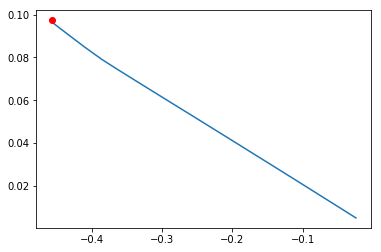

[[ 0.01940463 -0.01965435]
 [ 0.03032854 -0.03077801]
 [ 0.05378191 -0.05455922]
 [ 0.05378191 -0.05455922]
 [ 0.08975458 -0.09101971]
 [ 0.08975458 -0.09101971]
 [ 0.08975458 -0.09101971]
 [ 0.08975458 -0.09101971]
 [ 0.08975458 -0.09101971]
 [ 0.08975458 -0.09101971]
 [ 0.08975458 -0.09101971]
 [ 0.08975458 -0.09101971]
 [ 0.08975458 -0.09101971]
 [ 0.24891698 -0.25296486]
 [ 0.26009493 -0.26441671]
 [ 0.26009493 -0.26441671]
 [ 0.26009493 -0.26441671]
 [ 0.31778332 -0.32365521]
 [ 0.32473542 -0.3308002 ]
 [ 0.32577836 -0.33006996]]


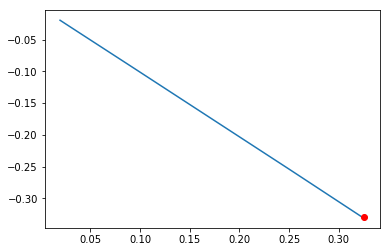

[[-0.0221004  -0.01219669]
 [-0.04439243 -0.02448648]
 [-0.06636509 -0.03659006]
 [-0.08897648 -0.04901951]
 [-0.11154723 -0.06159327]
 [-0.13362441 -0.07411116]
 [-0.15572481 -0.08663371]
 [-0.17821427 -0.09931299]
 [-0.19962512 -0.11144373]
 [-0.22285639 -0.12457379]
 [-0.24521229 -0.137236  ]
 [-0.26641846 -0.14919992]
 [-0.2891576  -0.16204834]
 [-0.3114235  -0.17461512]
 [-0.33214771 -0.18633387]
 [-0.35513944 -0.19938323]
 [-0.37743147 -0.21199889]
 [-0.3998135  -0.22464869]
 [-0.42124903 -0.23676468]
 [-0.4202061  -0.23603444]]


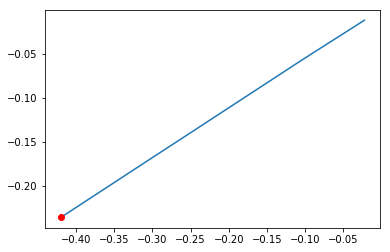

[[ 0.02089125  0.00444729]
 [ 0.04515113  0.00963631]
 [ 0.06745235  0.01438076]
 [ 0.08975198  0.01909573]
 [ 0.11147104  0.02374164]
 [ 0.13297476  0.02983998]
 [ 0.15193288  0.03859181]
 [ 0.1676372   0.04871304]
 [ 0.18287419  0.05896694]
 [ 0.19802187  0.06922318]
 [ 0.21302758  0.07937157]
 [ 0.2273634   0.08905443]
 [ 0.24143126  0.09855109]
 [ 0.25493928  0.10776455]
 [ 0.26873758  0.11719448]
 [ 0.2823397   0.12644131]
 [ 0.29649688  0.13607219]
 [ 0.30996183  0.14528953]
 [ 0.32026869  0.15235073]
 [ 0.32131163  0.15308097]]


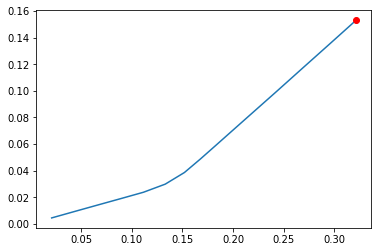

[[ 0.          0.        ]
 [ 0.00495725 -0.03520203]
 [ 0.00740572 -0.0535343 ]
 [ 0.01022097 -0.06968792]
 [ 0.0124869  -0.08560879]
 [ 0.01520669 -0.10350037]
 [ 0.01768531 -0.11961365]
 [ 0.02143674 -0.14190674]
 [ 0.02639398 -0.16950989]
 [ 0.03001143 -0.19450378]
 [ 0.03288027 -0.2126964 ]
 [ 0.03459689 -0.22279823]
 [ 0.03459689 -0.22279823]
 [ 0.0407298  -0.26298523]
 [ 0.0440123  -0.2855072 ]
 [ 0.04896955 -0.3139801 ]
 [ 0.05298894 -0.34048462]
 [ 0.05573552 -0.35861206]
 [ 0.05636355 -0.37120677]
 [ 0.05740648 -0.37047653]]


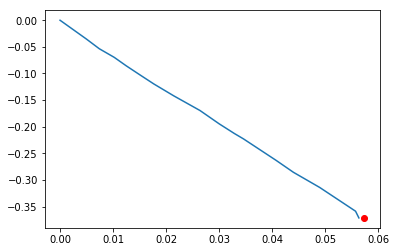

In [178]:
test_pred = seq(test_input).data.squeeze(1).numpy()[:, -2:]
for i in range(test_input.size(0)):
    latlon = test_input[i].data.numpy()[:, -2:]
    latlon = np.insert(latlon, latlon.shape[0], test_pred[i], axis=0)
    path = latlon.cumsum(axis=0)
    print(path)
    pathx, pathy = np.split(path, 2, axis=1)
    plt.plot(pathx[:-1], pathy[:-1])
    plt.plot(pathx[-1], pathy[-1], 'ro')
    plt.show()

In [ ]:
for i in range(10):
#print(input[i])
    print(seq(input[i].unsqueeze(0)).data[0])

In [99]:
h_t = Variable(torch.zeros(1, 5).float(), requires_grad=False)
c_t = Variable(torch.zeros(1, 5).float(), requires_grad=False)
cell = nn.LSTMCell(5, 5)

ip = Variable(torch.from_numpy(np.array([0., 1., 2., 3., 4.])).float(), requires_grad=False)
print(cell(ip.unsqueeze(0), (h_t, c_t)))
ip = Variable(torch.from_numpy(np.array([1., 1., 2., 3., 4.])).float(), requires_grad=False)
print(cell(ip.unsqueeze(0), (h_t, c_t)))

(Variable containing:
 0.2573 -0.0055  0.0220  0.2829  0.0796
[torch.FloatTensor of size 1x5]
, Variable containing:
 0.4565 -0.1485  0.0525  0.3668  0.1098
[torch.FloatTensor of size 1x5]
)
(Variable containing:
 0.2505 -0.0037  0.0671  0.2491  0.0472
[torch.FloatTensor of size 1x5]
, Variable containing:
 0.5474 -0.0877  0.1990  0.3101  0.0639
[torch.FloatTensor of size 1x5]
)
